# Differentiable Physics with `JAX`
**A 5 Minute Technical Overview with Examples**

<a target="_blank" href="https://colab.research.google.com/github/JeremyPohly/diffphys/blob/main/ballistics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Background & Motivation

- **Physics-based modeling** is the backbone of engineering and scientific simulation.
- Traditional pipelines (CFD, FEM, thermal, *etc*. sims) involve:
  - Solving ODEs/PDEs
  - No easy way to compute gradients
  - **Tuning parameters by hand/trial and error**

**Example**
- Simulated freely flying insects for my doctoral work
- High degree-of-freedom system
  - Body parameters - mass, inertia, center of gravity, etc.
  - Abdoment - mass, inertia, kinematics 
  - Wings - mass, inertia, structural, kinematics $\rightarrow$ aerodynamics
- Very difficult to understand effects small changes in parameters have on
resulting body motion
- Very expensive to evaluate cost function for unsteady, tightly-coupled CFD simulations
- No closed form expression solution for 1st order, gradient-based optimizers

In [1]:
from IPython.display import Video
Video("./media/animate_combined_inertial_body.mp4")

> Numerical solution for highly nonlinear trajectory of freely flying monarch butterfly

**Enter differentiable physics:**
- Combine physical models with **automatic differentiation (autodiff)**.
- Enables:
  - Gradient-based optimization (e.g. control, design, calibration)
\begin{aligned}
  {x}_{n+1} = {x}_n - \gamma \underbrace{\nabla_{x}f({x})}_\text{typically not known}
\end{aligned}
  - Physics-informed machine learning
    - Don't learn the physics from scratch
    - Learn the missing physics by differentiating through
    what we already know
  - Inverse problems and real-time sensitivity analysis
    - Utilize gradient-based optimization
    - Efficiently determine inputs required for some known output
    - Useful in matching M&S to experiments


**Why JAX?**
- NumPy-like syntax, GPU/TPU acceleration
- Native `grad`, `jacfwd`, `jit`, `vmap`, and `lax.scan` tools
- Great for integrating simulation + learning



## Motivating Example: Ballistic Motion

![](./media/ballistic_01.svg)
> Simple 2-DOF ballistic motion

- Simple, intuitive physical system
- Great way to show:
  - Closed-form vs. simulation-based approaches
  - Where autodiff becomes essential
- Lets us explore a realistic modeling pipeline without complexity overhead

**Highlighting differentiable physics:**
- Gradient-based optimization for inverse problem:
  - Solve for launch angle and velocity to hit desired target location $(x_t, y_t)$
  - Could also be viewd as: Given the landing point of projectile, what was the initial launch angle and velocity?
- Differentiable physics:
  - What drag coefficient was used to generate a given trajectory?

### Equations of Motion

\begin{align}
    \ddot{x} = -C_d^* v \dot{x} \\
    \ddot{y} = -g - C_d^* v \dot{y}
\end{align}
 
where 
 

In [2]:
import jax
import jax.numpy as jnp
from stepper import BallisticStepper
from rollout import rollout

# Create two steppers with different drag coefficients.
# One for a vacuum (no drag) and one for an atmosphere (with drag).
stepper_vac = BallisticStepper(cd=0.0, dt=0.005)
stepper_atm = BallisticStepper(cd=0.001, dt=0.005)

# Define initial conditions:
v_mag_0 = 100.0
theta_0 = jnp.deg2rad(35.0)
# Initial velocity in the x and y directions:
x_dot_0, y_dot_0 = [v_mag_0 * jnp.cos(theta_0), v_mag_0 * jnp.sin(theta_0)]

# Construct the initial state:
state_0 = jnp.array([0.0, 0.0, x_dot_0, y_dot_0])

# Create the trajectories by unrolling the steppers
trj_vac = rollout(stepper_vac, n_steps=5_000, include_init=True)(state_0)
trj_atm = rollout(stepper_atm, n_steps=5_000, include_init=True)(state_0)

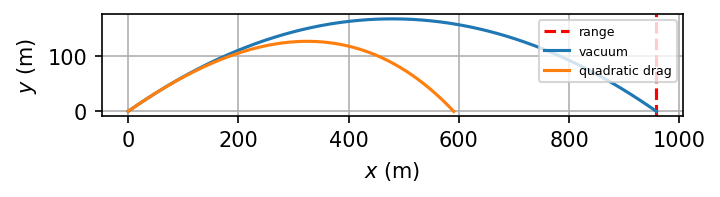

In [3]:
# Plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect("equal")

xf = lambda theta, v_mag: v_mag**2 * jnp.sin(2. * theta) / 9.81
ax.axvline(xf(theta_0, v_mag_0), c="r", ls="--", label="range")
ax.plot(trj_vac[:,0], trj_vac[:,1], label="vacuum")
ax.plot(trj_atm[:,0], trj_atm[:,1], label="quadratic drag")
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"$y$ (m)")
ax.grid()
ax.legend(fontsize=6)

## Stage 1: Simple Ballistic Motion — Flat Ground (`y_f = 0`)

**Problem Setup:**
- Model: constant gravity, no drag.
- Launch parameters: initial speed `v0`, angle `theta0`.
- Impact height: `y_f = 0`.

**Closed-form solution:**
Can solve for $x_f$:
  - First solve $t_f$ from $y(t_f) = 0$
  - Then solve $x_f = x(t_f)$ 
\begin{aligned}
x_f = \frac{v_0^2 \sin(2\theta)}{g}
\end{aligned}

**Jacobian (partial derivatives):**

\begin{aligned}
  \nabla_{x_f}f(x_f)
\end{aligned}

\begin{aligned}
\frac{\partial x_f}{\partial v_0} = \frac{2v_0 \sin(2\theta)}{g}, \quad
\frac{\partial x_f}{\partial \theta} = \frac{2v_0^2 \cos(2\theta)}{g}
\end{aligned}

**Why it matters:**
- Demonstrates analytical overhead
- Validates analytical/numerical gradient solutions

In [4]:
dx_dv0 = 2 * v_mag_0 * jnp.sin(2*theta_0) / 9.81
dx_dtheta = 2 * v_mag_0**2 / 9.81 * jnp.cos(2 * theta_0)
print(f"dx/dv0 = {dx_dv0:.2f} m/s")
print(f"dx/dtheta = {dx_dtheta:.2f} m/rad")

dx/dv0 = 19.16 m/s
dx/dtheta = 697.29 m/rad


In [5]:
# Need to deterimine a precise value for the x-coordinate of the ground crossing
def interpolate_ground_crossing(trj):
    ys = trj[:, 1]
    crossing_idx = jnp.argmax(ys < 0)  # first index where y < 0

    state_before = trj[crossing_idx - 1]
    state_after = trj[crossing_idx]

    y0, y1 = state_before[1], state_after[1]
    x0, x1 = state_before[0], state_after[0]

    frac = y0 / (y0 - y1 + 1e-6)
    x_cross = x0 + frac * (x1 - x0)
    return x_cross

In [6]:
# Compute the gradient of the final x-location with respect to the input parameters
def final_state_fn(params, stepper):
    """
    Simulate the vacuum trajectory.
    Here, we want to input the initial states as v0, theta0
    and get the final state as x, y, vx, vy.
    """
    v0, theta0 = params
    x_dot_0, y_dot_0 = [v0 * jnp.cos(theta0), v0 * jnp.sin(theta0)]
    state_0 = jnp.array([0.0, 0.0, x_dot_0, y_dot_0])
    trj = rollout(stepper=stepper, n_steps=5_000, include_init=True)(state_0)
    # return trj[-1, 0] # final x position
    return interpolate_ground_crossing(trj)


In [7]:
from jax import grad
grad_fn = jax.grad(final_state_fn, argnums=0)
params = jnp.array([v_mag_0, theta_0])
grad = grad_fn(params, stepper_vac)
print(f"dx/dv0 = {grad[0]:.2f} m/s")
print(f"dx/dtheta = {grad[1]:.2f} m/rad")

dx/dv0 = 19.16 m/s
dx/dtheta = 697.24 m/rad


## Example 2: Including Drag & Solving for Desired $x_f$

**Problem Setup:**
- Model: constant gravity, **with drag**.
- Launch parameters: initial speed `v0`, angle `theta0`.
- Impact height: `y_f = 0`.

**Closed-form solution:**
None

**Why it matters:**
- Demonstrates finding gradients when no analytical solution exists
- Scales to high DOF nonlinear systems

### Loss Function:

We define a simple `mse`-like loss function where

\begin{aligned}
  f_\text{loss} = (x_\text{final} - x_\text{desired})^2
\end{aligned}

In [ ]:
# Define a loss function to minimize
def loss_fn(params, stepper, x_target):
    x_f = final_state_fn(params, stepper)
    return (x_f - x_target)**2


loss = 0.15


We can test it against the analytical solution for $v_o$ and $\theta_o$ that are required for a desired $x_f$.

In [73]:
# Test the loss on known values for vacuum case:
# Will also set our tolerance for the optimizer
x_target = xf(theta_0, v_mag_0)
params = jnp.array([v_mag_0, theta_0])
loss = loss_fn(params, stepper_vac, x_target)
print(f"loss = {loss:.2f}")

loss = 0.15


Now we create the optimization loop where we apply a simple gradient descent as described before, which is doable using the `JAX`-calculated gradients of the final position w.r.t the initial conditions $v_o$ and $\theta_o$.

In [ ]:
# Define the loss function and its gradient
grad_fn = jax.grad(loss_fn, argnums=0)

# Set initial guess for the optimizer
initial_v0 = 110.0
initial_theta = jnp.deg2rad(60.0)
params = jnp.array([initial_v0, initial_theta])

# Set hyperparameters for the optimizer
n_iters = 20
lr_v = 1e-3
lr_theta = 5e-7
tolerance = 1e-3

# Track the parameters
param_list = []

# Gradient descent loop
for i in range(n_iters):
    loss = loss_fn(params, stepper_vac, x_target)
    grads = grad_fn(params, stepper_vac, x_target)
    params = params.at[0].add(-lr_v * grads[0])
    params = params.at[1].add(-lr_theta * grads[1])
    param_list.append(params)
    print(f"iter {i}: loss = {loss:.2f}, params = {params[0], jnp.rad2deg(params[1])}") 
    if loss < tolerance:
        print("Converged")
        break


iter 0: loss = 12236.99, params = (Array(105.70252, dtype=float32), Array(67.82077, dtype=float32))
iter 1: loss = 26044.43, params = (Array(110.5657, dtype=float32), Array(52.75686, dtype=float32))
iter 2: loss = 59169.34, params = (Array(99.9957, dtype=float32), Array(62.050507, dtype=float32))
iter 3: loss = 12918.89, params = (Array(103.83386, dtype=float32), Array(54.604137, dtype=float32))
iter 4: loss = 6444.36, params = (Array(100.62435, dtype=float32), Array(57.93325, dtype=float32))
iter 5: loss = 835.90, params = (Array(101.69201, dtype=float32), Array(56.440815, dtype=float32))
iter 6: loss = 184.47, params = (Array(101.173096, dtype=float32), Array(57.079212, dtype=float32))
iter 7: loss = 31.38, params = (Array(101.383995, dtype=float32), Array(56.804974, dtype=float32))
iter 8: loss = 5.99, params = (Array(101.29132, dtype=float32), Array(56.922695, dtype=float32))
iter 9: loss = 0.99, params = (Array(101.32893, dtype=float32), Array(56.87445, dtype=float32))
iter 10: lo

### Analyze Solution and Utilize `jax.vmap` for Parallel Trajectory Solutions

In [ ]:
# Run the final trajectory
state_0 = jnp.array([0.0, 0.0, params[0] * jnp.cos(params[1]), params[0] * jnp.sin(params[1])])
trj_final = rollout(stepper_vac, n_steps=5_000, include_init=True)(state_0)

In [ ]:
# Create initial conditions from all of the param_list values
states_0 = []
for p in param_list:
    v0, theta0 = p
    x_dot_0, y_dot_0 = [v0 * jnp.cos(theta0), v0 * jnp.sin(theta0)]
    state_0 = jnp.array([0.0, 0.0, x_dot_0, y_dot_0])
    states_0.append(state_0)
states_0 = jnp.stack(states_0)

# Batch rollout across all initial conditions using jnp.vmap
trj_all = jax.vmap(rollout(stepper_vac, n_steps=5_000, include_init=True), in_axes=(0,))(states_0)

### Plot Final Solution

15


Text(0.5, 0, '$x$ (m)')

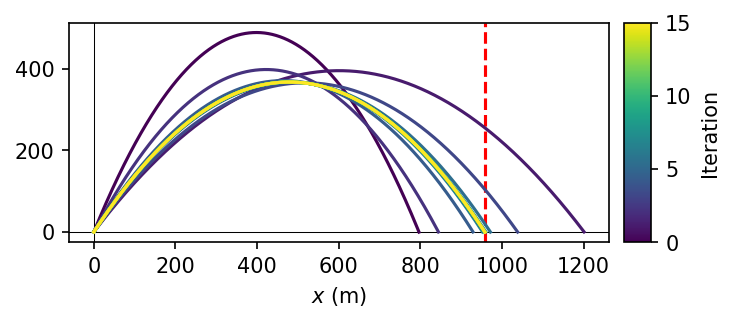

In [ ]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure
fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.axhline(0, c="k", lw=0.5)
ax.axvline(0, c="k", lw=0.5)
ax.axvline(xf(theta_0, v_mag_0), c="r", ls="--", label="range")

# Create viridis color map for each line in trj_all
cmap = matplotlib.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(trj_all)))
for trj, c in zip(trj_all, colors):
    ax.plot(trj[:,0], trj[:,1], c=c, alpha=1.0)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(trj_all)))
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Iteration")
ax.set_xlabel(r"$x$ (m)")

## Example Progression

### 1. **Flat Ground, No Drag**  
- Closed-form:
  \begin{aligned}
  x_f = \frac{v_0^2 \sin(2\theta)}{g}
  \end{aligned}
- Use `jax.grad()` to verify with autodiff

### 2. **Elevated Target (`y_f ≠ 0`)**  
- Requires numerical integration
- Use `lax.scan` and interpolation to find ground-crossing
- `jax.jacfwd()` gives sensitivity w.r.t. `v_0`, `θ`

### 3. **Quadratic Drag**  
- Realistic dynamics: 
  \[
  \vec{a} = -g\hat{j} - k|\vec{v}|\vec{v}
  \]
- No closed form → full autodiff pipeline with `jax.scan + grad`

### 4. Applications: Inverse Learning and Gradient-based Parameter Estimation
- Define loss:  
  \[
  \text{loss} = (x_f - x_{\text{target}})^2
  \]
- Use gradients to find optimal `v_0, θ` via gradient descent or Newton

---


## Other Features

### Convenient Batch Processing: Efficient Monte-carlo Simulations

### Auto-regressive Machine-Learning Dynamics Stepper

## Broader Applications

### Fluid Dynamics
- Use `jax-fluids` or roll your own Navier-Stokes solver
- Differentiable solvers enable:
  - Optimal flow control
  - Inverse design (e.g., airfoils, heat exchangers)

### Finite Element Methods (FEM)
- Libraries like `jax-fem` let you solve elasticity, diffusion, etc.
- Backprop through the solver → useful for:
  - Material property inference
  - Data-driven constitutive modeling

### ML-Physics Fusion
- Replace parts of your model with learned surrogates (hybrid modeling)
- Use PINNs (Physics-Informed Neural Networks)
- Gradient-based tuning of physical parameters from data

---

## Conclusion

- **JAX enables differentiable simulation**, blending physics and ML.
- Even for simple systems like ballistic motion, the value of autodiff emerges quickly.
- As complexity grows, autodiff becomes indispensable.
- Use cases span:
  - Aerospace trajectory optimization
  - Inverse CFD/FEM problems
  - Scientific ML and hybrid models
